# Probabilistic Programming in Pyro

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

## Introduction

In this post, I will look at a simple application:

Is the number of COVID cases changing over time? 

![](cases-raw.png)

I will not be using real data and this post will be purely educational in nature.

The main aim of this post is to review some distributions and concepts in probabilistic programming.

The post is heavily inspired (copied and modified) by the excellent book called [Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) (BMH). I am also borrowing a small subset of code from a [forked repository](https://github.com/ucals/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) for BMF containing some code in Pyro.

Eventually, we should be able to learn something like the following image, where we detect the changepoint and also the values before and after the change.

![](cases-annotated.png)


In [2]:
import torch
import pyro
import numpy as np

pyro.set_rng_seed(101)
import matplotlib.pyplot as plt
import pandas as pd
from pyro.infer import MCMC, NUTS, HMC
import pyro.distributions as dist
plt.style.use('seaborn-colorblind')


## Distributions in Pyro

We will first look at some distributions in Pyro to understand the task better.

We first start with the unfirom distribution between 0 and 100 and generate 1000 samples. 

In [20]:
u = torch.distributions.Uniform(0, 100)

Text(0.5, 0, 'z')

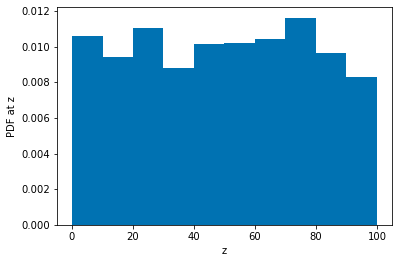

In [26]:
n=1000
s = pd.Series(u.sample((n, )))
s.hist(density=True, grid=False, bins=10 )
plt.ylabel("PDF at z")
plt.xlabel("z")
plt.title("Uniform Distribution")

As expected, all values in \[0, 100\] are equally likely. 

We next look at the Categorical distribution which is a discrete distribution. Using it, we can create a discrete uniform distribution over \[0, 10\].

In [27]:
du = torch.distributions.Categorical(torch.tensor([1./n for _ in range(10)]))

In [28]:
n = 1000
du_samples = du.sample((n, ))

Text(0.5, 1.0, 'Discrete Uniform Distribution')

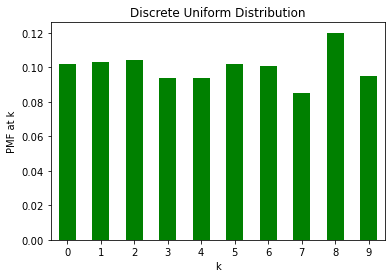

In [30]:
du_series = pd.Series(du_samples).value_counts().sort_index()
du_prop = du_series/n
du_prop.plot(kind='bar',rot=0, color='green')
plt.ylabel("PMF at k")
plt.xlabel("k")
plt.title("Discrete Uniform Distribution")

We next look at the exponential distribution. It is controlled by a parameter $\lambda$ with the expected value of the random variable being $\dfrac{1}{\lambda}$

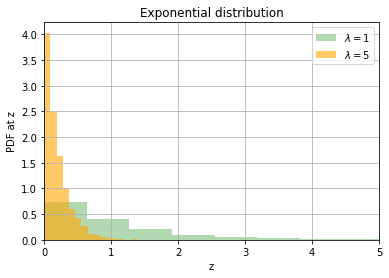

In [40]:
exp1 = torch.distributions.Exponential(1)
exp2 = torch.distributions.Exponential(5)


s1 = pd.Series(exp1.sample((5000, )))
s2 = pd.Series(exp2.sample((5000, )))


s1.hist(density=True, alpha=0.3, bins=20, color='g', label=r'$\lambda = 1$')
s2.hist(density=True, alpha=0.6, bins=20, color='orange',label=r'$\lambda = 5$')
plt.xlim((0, 5))

plt.ylabel("PDF at z")
plt.xlabel("z")
plt.title("Exponential distribution")
plt.legend()

We finally look at the Poisson distribution. It is controlled by a parameter $\lambda$ with the expected value of the random variable being ${\lambda}$. Poisson is a discrete distribution often used for modelling count data.  

Text(0.5, 1.0, 'Poisson Distribution')

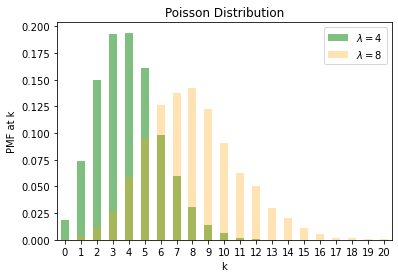

In [60]:
p1 = torch.distributions.Poisson(4)
p2 = torch.distributions.Poisson(8)


s1 = pd.Series(p1.sample((5000, )))
s2 = pd.Series(p2.sample((5000, )))

s1 = s1.astype('int').value_counts().sort_index()
s1 = s1/5000

s2 = s2.astype('int').value_counts().sort_index()
s2 = s2/5000

s1.plot.bar(color='g', alpha=0.5, label=r'$\lambda = 4$', rot=0)
s2.plot.bar(color='orange', alpha=0.3, label=r'$\lambda = 8$', rot=0)

plt.legend()
plt.ylabel("PMF at k")
plt.xlabel("k")
plt.title("Poisson Distribution")

## Creating the dataset

We will be creating the dataset for daily COVID count with

- Before day number 30, the cases are Poisson distributed with mean of 30
- After day number 30, the cases are Poisson distributed with mean of 40
- We have data for a total of 50 days

In [105]:
gt_tau = 30
gt_lambda_1 = 30
gt_lambda_2 = 40

def sample(day):
    if day < gt_tau:
        l = gt_lambda_1
    else:
        l = gt_lambda_2
    
    return torch.distributions.Poisson(l).sample()

In [106]:
data = np.array([sample(day) for day in range(50)])

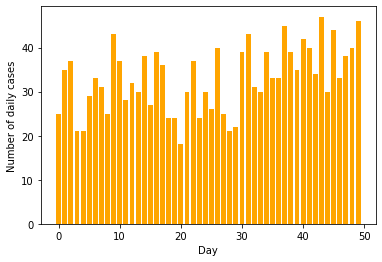

In [116]:
plt.bar(range(50), data, color='orange')
plt.xlabel("Day")
plt.ylabel("Number of daily cases")
plt.savefig("cases-raw.png")

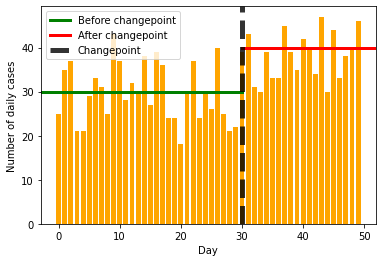

In [132]:
plt.bar(range(50), data, color='orange')
plt.xlabel("Day")
plt.ylabel("Number of daily cases")
plt.axhline(30, 0, 30/50, label='Before changepoint', lw=3, color='green')
plt.axhline(40, 30/50, 1, label='After changepoint', lw=3, color='red')
plt.axvline(30, label='Changepoint', lw=5, color='black', alpha=0.8, linestyle='--')


plt.legend()
plt.savefig("cases-annotated.png")

## Modelling

We will now assume that we received the data and need to create a model.

We choose the following model

$$C_{i} \sim \operatorname{Poisson}(\lambda)$$

$$\lambda= \begin{cases}\lambda_{1} & \text { if } t<\tau \\ \lambda_{2} & \text { if } t \geq \tau\end{cases}$$

$$\begin{aligned}
&\lambda_{1} \sim \operatorname{Exp}(\alpha) \\
&\lambda_{2} \sim \operatorname{Exp}(\alpha)
\end{aligned}
$$

In [110]:
def model(data):
    alpha = 1.0 / data.mean()
    lambda_1 = pyro.sample("lambda_1", dist.Exponential(alpha))
    lambda_2 = pyro.sample("lambda_2", dist.Exponential(alpha))
    
    tau = pyro.sample("tau", dist.Uniform(0, 1))
    lambda1_size = (tau * data.size(0) + 1).long()
    lambda2_size = data.size(0) - lambda1_size
    lambda_ = torch.cat([lambda_1.expand((lambda1_size,)),
                         lambda_2.expand((lambda2_size,))])

    with pyro.plate("data", data.size(0)):
        pyro.sample("obs",dist.Poisson(lambda_), obs=data)

## Inference button

In [112]:
kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=3)
posterior = MCMC(kernel, num_samples=5000, warmup_steps=2000)
posterior.run(torch.from_numpy(data));

Sample: 100%|██████████| 7000/7000 [00:33, 210.22it/s, step size=1.06e-02, acc. prob=0.963]


## Obtaining and plotting the posteriors

In [113]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}
lambda_1_samples = hmc_samples['lambda_1']
lambda_2_samples = hmc_samples['lambda_2']
tau_samples = (hmc_samples['tau'] * torch.from_numpy(data).size(0) + 1).astype(int)

Text(0.5, 1.0, '$\\lambda_2$')

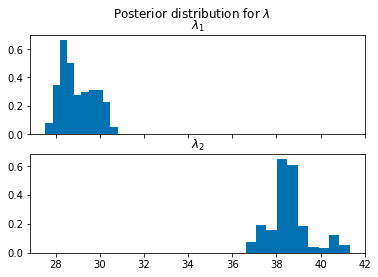

In [139]:
fig, ax  = plt.subplots(nrows=2, sharex=True)
ax[0].hist(lambda_1_samples, density=True)
ax[1].hist(lambda_2_samples, density=True)
plt.suptitle(r"Posterior distribution for $\lambda$")
ax[0].set_title(r"$\lambda_1$")
ax[1].set_title(r"$\lambda_2$")

Text(0, 0.5, '$P(\\tau=k)$')

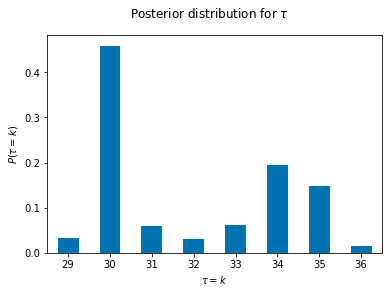

In [144]:
(pd.Series(tau_samples).value_counts()/5000).sort_index().plot(kind='bar',rot=0)
plt.suptitle(r"Posterior distribution for $\tau$")
plt.xlabel(r"$\tau=k$")
plt.ylabel(r"$P(\tau=k)$")

In [ ]:
It seems from our posterior that we have obtained a fairly good estimate our simulation parameters.